In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pixelcnn/mnist_kaggle.pth
/kaggle/input/pixelcnn/__results__.html
/kaggle/input/pixelcnn/__notebook_source__.ipynb
/kaggle/input/pixelcnn/__notebook__.ipynb
/kaggle/input/pixelcnn/mnist.pth
/kaggle/input/pixelcnn/__output__.json
/kaggle/input/pixelcnn/mnist2.pth
/kaggle/input/pixelcnn/sample2.png
/kaggle/input/pixelcnn/sample.png
/kaggle/input/pixelcnn/custom.css
/kaggle/input/pixelcnn/__results___files/__results___5_1.png
/kaggle/input/pixelcnn/__results___files/__results___16_1.png


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms


from torchvision.datasets import MNIST
from torch.autograd import Variable
torch.cuda.empty_cache()

Creation of the PixelCNN model 

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


class MaskedConv2D(nn.Conv2d):
    def __init__(self,mask_type, *args, **kwargs):
        super(MaskedConv2D, self).__init__(*args, **kwargs)
        self.mask_type = mask_type
        assert mask_type in ['A', 'B'], "Unknown Mask Type"
        self.register_buffer('mask', self.weight.data.clone())
        _, depth, height, width = self.weight.size()
        self.mask.fill_(1)
        if mask_type =='A':
            self.mask[:,:,height//2,width//2:] = 0
            self.mask[:,:,height//2+1:,:] = 0
        else:
            self.mask[:,:,height//2,width//2+1:] = 0
            self.mask[:,:,height//2+1:,:] = 0

    def forward(self, x):
        self.weight.data*=self.mask
        return super(MaskedConv2D, self).forward(x)




class PixelCNN_MNIST(nn.Module):
    def __init__(self,in_channels=1, out_channels=1, nb_layer_block=12, 
                 h_channels=32, device=None):
        super(PixelCNN_MNIST, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.nb_block = nb_layer_block
        self.h_channels = h_channels
        self.layers = {}
        self.device = device
        #first convolution (cf TABLE 1)
        self.ConvA = nn.Sequential(
            MaskedConv2D('A',in_channels, 2*self.h_channels, kernel_size=7,padding="same", bias=True),
            nn.ReLU(True)
        )
        #Residual blocks for PixelCNN (figure 5)
        self.multiple_blocks = nn.Sequential(
            nn.Conv2d(2*self.h_channels, self.h_channels, kernel_size = 1,padding='same', bias=True),
            nn.ReLU(True),
            MaskedConv2D('B',self.h_channels,self.h_channels, kernel_size = 3,padding='same', bias=True),
            nn.ReLU(True),
            nn.Conv2d(self.h_channels,2*self.h_channels, kernel_size = 1,padding='same', bias=True),
            nn.ReLU(True)
        )
        #finalisation
        
        self.end_mnist = nn.Sequential(
            MaskedConv2D('B',2*self.h_channels, 2 * self.h_channels, padding ='same',kernel_size = 1, bias=True),
            nn.ReLU(True),
            MaskedConv2D('B',2* self.h_channels,2*self.h_channels,padding='same', kernel_size = 1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(2*self.h_channels,self.out_channels,padding='same',kernel_size = 1, bias=True),
        )

    def residual_block(self, x):
        return (x + self.multiple_blocks(x))

    def forward(self,x,**kwargs):
        x = self.ConvA(x)

        for i in range(self.nb_block):
            x = self.residual_block(x)
        
        x = self.end_mnist(x)


        return x


cuda:0


In [29]:
class PixelCNN_CIFAR(nn.Module):
    def __init__(self,in_channels=3, out_channels=3, nb_layer_block=12, 
                 h_channels=128, device=None):
        super(PixelCNN_CIFAR, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.nb_block = nb_layer_block
        self.h_channels = h_channels
        self.device = device
        #first convolution (cf TABLE 1)
        self.ConvA = nn.Sequential(
            MaskedConv2D('A',in_channels, 2*self.h_channels, kernel_size=7,padding="same", bias=True),
            nn.ReLU(True)
        )
        #Residual blocks for PixelCNN (figure 5)
        self.multiple_blocks = nn.Sequential(
            nn.Conv2d(2*self.h_channels, self.h_channels, kernel_size = 1,padding='same', bias=True),
            nn.ReLU(True),
            MaskedConv2D('B',self.h_channels,self.h_channels, kernel_size = 3,padding='same', bias=True),
            nn.ReLU(True),
            nn.Conv2d(self.h_channels,2*self.h_channels, kernel_size = 1,padding='same', bias=True),
            nn.ReLU(True)
        )
        #finalisation
        self.end_cifar = nn.Sequential(
            MaskedConv2D('B',2*self.h_channels, 2 * self.h_channels, padding ='same',kernel_size = 1, bias=True),
            nn.ReLU(True),
            MaskedConv2D('B',2* self.h_channels,2 * self.h_channels,padding='same', kernel_size = 1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(2*self.h_channels,self.out_channels,padding='same',kernel_size = 1, bias=True),
            #nn.Softmax()
        )
        

    def residual_block(self, x):
        return (x + self.multiple_blocks(x))

    def forward(self,x,**kwargs):
        x = self.ConvA(x)

        for i in range(self.nb_block):
            x = self.residual_block(x)
        
        x = self.end_cifar(x)

        return x

Training the model ( MNIST or CIFAR10)

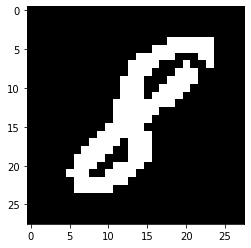

In [33]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: x>0,
                       lambda x: x.float(),
            ])),
    batch_size=batch_size, shuffle=True,pin_memory=True)

x, _ = train_loader.dataset[7777]
plt.imshow(x.numpy()[0], cmap='gray')

In [34]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model = model.to(device)
    for batch, (X, y) in enumerate(dataloader):
        target = Variable(X[:,:,:,:])
        X = X.to(device)
        target = target.to(device)
        # Compute prediction and loss
        pred = model(X)
        pred = pred[:,:,:,:] 
        #print(pred)
        
        loss = loss_fn(pred,target)

        # Backpropagation (always in three steps)
        optimizer.zero_grad() # a toujours mettre pour pas accumuler les gradients
        loss.backward()
        optimizer.step()

        if batch % 1500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [35]:
model_MNIST = PixelCNN_MNIST()

# Hyperparameters for MNIST 
epochs = 4
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model_MNIST.parameters(),lr=0.001,alpha=0.9)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader,model_MNIST,loss_fn,optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.787157  [    0/60000]
loss: 0.090848  [24000/60000]


KeyboardInterrupt: 

Files already downloaded and verified


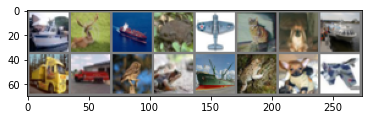

In [30]:
#CIFAR DATASET
batch_size_cifar = 16
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader_cifar = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform),
    batch_size=batch_size_cifar, shuffle=True,pin_memory=True)

dataiter = iter(train_loader_cifar)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [31]:
def train_loop_cifar(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model = model.to(device)
    for batch, (X, y) in enumerate(dataloader):
        target = Variable(X[:,:,:,:])
        X = X.to(device)
        target = target.to(device)
        # Compute prediction and loss
        pred = model(X)
        pred = pred[:,:,:,:] 
        loss = loss_fn(pred,target)

        # Backpropagation (always in three steps)
        optimizer.zero_grad() # a toujours mettre pour pas accumuler les gradients
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = torch.exp(loss.item()), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [92]:

model_cifar = PixelCNN_CIFAR()

# Hyperparameters for CIFAR
epochs = 4
loss_fn = nn.NLLLoss()
optimizer = torch.optim.RMSprop(model_cifar.parameters(),lr=0.001,alpha=0.9)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_cifar(train_loader_cifar,model_cifar,loss_fn,optimizer)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [16, 3, 32, 32]

In [34]:
#Saving the network
PATH = './cifar_kaggle.pth'
torch.save(model_cifar.state_dict(), PATH)

In [77]:
def test_MNIST():

    PATH = '/kaggle/working/mnist_kaggle.pth'
    assert os.path.exists(PATH), 'Saved Model File Does not exist!'
    no_images = 9
    images_size =  28
    images_channels =  1

    #Define and load model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = PixelCNN_MNIST().to(device)
    global init_param
    init_param = model.parameters()
    model.load_state_dict(torch.load(PATH,map_location=device))
    model.eval()
    global test_param
    test_param = model.parameters()
    sample = torch.Tensor(no_images, images_channels, images_size, images_size).to(device)
    sample.fill_(0)

    #Generating images pixel by pixel
    # A PATCHER 
    for i in range(images_size):
        for j in range(images_size):
            out = model(sample)
            probs = torch.sigmoid(out[:,:,i,j])
            results = torch.bernoulli(probs)
            sample[:,:,i,j] = results
    #Saving images row wise
    '''print(out.size())
    print(probs)
    print(results)
    print(sample)
    '''
    torchvision.utils.save_image(sample, '/kaggle/working/sample2.png',ncol=3, nrow=3, padding=0)

    pass

In [78]:
essai = test_MNIST()

cuda:0


print(essai)

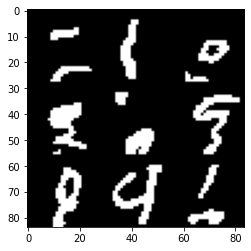

In [79]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('sample2.png'))

In [122]:
def test_CIFAR():

    PATH = '/kaggle/working/cifar_kaggle.pth'
    assert os.path.exists(PATH), 'Saved Model File Does not exist!'
    no_images = 2
    images_size =  32
    images_channels =  3

    #Define and load model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = PixelCNN_CIFAR().to(device)
    global init_param
    init_param = model.parameters()
    model.load_state_dict(torch.load(PATH,map_location=device))
    model.eval()
    global test_param
    test_param = model.parameters()
    sample = torch.Tensor(no_images, images_channels, images_size, images_size).to(device)
    sample.fill_(0)

    #Generating images pixel by pixel
    # A PATCHER 
    for i in range(images_size):
        for j in range(images_size):
            for k in range(images_channels):
                out = model(sample)
                probs = F.softmax(out[:,k,i,j])
                results = torch.multinomial(probs,1,replacement=True).float()
                sample[:,k,i,j] = results
    #Saving images row wise
    '''print(out.size())
    print(probs)
    print(results)
    print(sample)
    '''
    print(sample[1,:,:,:]==sample[0,:,:,:])
    torchvision.utils.save_image(sample, '/kaggle/working/sample3.png',ncol=1, nrow=2, padding=0)

    pass

In [123]:
essai = test_CIFAR()

cuda:0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

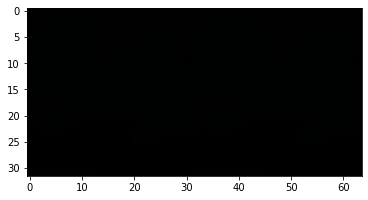

In [121]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
plt.imshow(mpimg.imread('sample3.png'))